In [1]:
cd ..

/work


# Lecture dataset

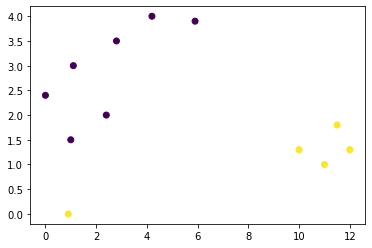

In [8]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/lecture_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscanrn_opt_cpp_lecture_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, numerate=False)

## OUT

In [9]:
pd.options.display.max_rows = None
name = 'dbscanrn_cpp_opt_lecture_dataset_D2_R12_k4_cosine_dissimilarity'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.003056,NaN
1,6.736978,start log,NaN,NaN,NaN
2,6.739288,normalization_time,NaN,0.001582,NaN
3,6.740699,pessimistic_estimation_time,0.0,0.000693,NaN
4,6.741379,dist_to_ref_point_time,0.0,0.000035,NaN


In [10]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,4.2,4.0,1,2,4.0
1,1,5.9,3.9,1,2,4.0
2,2,2.8,3.5,1,2,4.0
3,3,12.0,1.3,1,3,4.0
4,4,10.0,1.3,1,3,4.0


## STAT

In [11]:
params = {
    'k': 4,
    'similarity': 'cosine_dissimilarity'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [12]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "knn_time [ms]": logs[logs['operation'] == 'knn_time']['value'].sum() * 1000,
    "rnn_time [ms]": logs[logs['operation'] == 'rnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.008196353912353516


,values
name of the input fil,lecture_dataset
# of dimensions of a point,2
# of points in the input file,12
epsilon,
minPts,
k,4
similarity,cosine_dissimilarity
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],3.056
normalization of vectors [ms],


## DEBUG

In [13]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,4.0,7;2;1;11;,4.0,7;2;1;11;
1,1.0,4.0,7;0;2;11;,4.0,7;0;2;11;
2,2.0,4.0,11;0;7;5;,4.0,11;0;7;5;
3,3.0,4.0,9;4;8;10;,4.0,9;4;8;10;
4,4.0,4.0,3;8;9;10;,4.0,3;8;9;10;


# Compound dataset

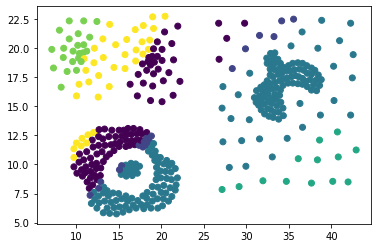

In [14]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/compound_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscanrn_opt_cpp_compound_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, numerate=False)

## OUT

In [15]:
pd.options.display.max_rows = None
name = 'dbscanrn_opt_cpp_compound_dataset_D2_R399_k6_cosine_dissimilarity_r01'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.004586,NaN
1,8.916338,start log,NaN,NaN,NaN
2,9.545832,normalization_time,NaN,0.628881,NaN
3,9.560884,pessimistic_estimation_time,0.0,0.013038,NaN
4,9.562195,dist_to_ref_point_time,0.0,0.000536,NaN


In [16]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,26.75,22.15,1,2,6.0
1,1,29.80,22.15,1,2,6.0
2,2,31.55,21.10,1,3,6.0
3,3,27.70,20.85,1,2,6.0
4,4,29.90,19.95,1,3,6.0


## STAT

In [17]:
params = {
    'k': 6,
    'similarity': 'cosine_dissimilarity'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [19]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "knn_time [ms]": logs[logs['operation'] == 'knn_time']['value'].sum() * 1000,
    "rnn_time [ms]": logs[logs['operation'] == 'rnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.016484737396240234


,values
name of the input fil,compound_dataset
# of dimensions of a point,2
# of points in the input file,399
epsilon,
minPts,
k,6
similarity,cosine_dissimilarity
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],4.5857
normalization of vectors [ms],


## DEBUG

In [20]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,6.0,215;243;231;272;273;265;,6.0,215;243;231;272;273;265;
1,1.0,6.0,321;223;275;322;266;280;,6.0,321;223;275;322;266;280;
2,2.0,6.0,325;4;329;330;334;282;,6.0,325;4;329;330;334;282;
3,3.0,6.0,280;266;279;275;223;316;,6.0,280;266;279;275;223;316;
4,4.0,6.0,2;325;330;329;334;282;,6.0,2;325;330;329;334;282;


# Jain dataset

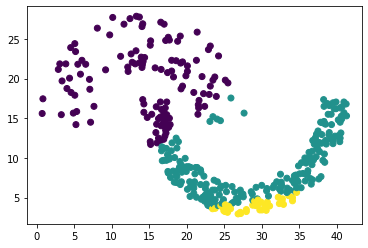

In [21]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/jain_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscanrn_opt_cpp_jain_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, numerate=False)

## OUT

In [22]:
name = 'dbscanrn_opt_cpp_jain_dataset_D2_R399_k7_cosine_dissimilarity_r01'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False,
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.004677,NaN
1,2.550708,start log,NaN,NaN,NaN
2,3.098429,normalization_time,NaN,0.547037,NaN
3,3.113546,pessimistic_estimation_time,0.0,0.012077,NaN
4,3.114890,dist_to_ref_point_time,0.0,0.000501,NaN


In [23]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,0.85,17.45,1,2,7.0
1,1,0.75,15.60,1,2,7.0
2,2,3.30,15.45,1,2,7.0
3,3,5.25,14.20,1,2,7.0
4,4,4.90,15.65,1,2,7.0


## STAT

In [24]:
params = {
    'k': 7,
    'similarity': 'cosine_dissimilarity'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [25]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "knn_time [ms]": logs[logs['operation'] == 'knn_time']['value'].sum() * 1000,
    "rnn_time [ms]": logs[logs['operation'] == 'rnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.015078067779541016


,values
name of the input fil,jain_dataset
# of dimensions of a point,2
# of points in the input file,373
epsilon,
minPts,
k,7
similarity,cosine_dissimilarity
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],4.6767
normalization of vectors [ms],


## DEBUG

In [26]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,7.0,1;10;11;9;12;23;24;,7.0,1;10;11;9;12;23;24;
1,1.0,7.0,0;10;11;9;12;23;24;,7.0,0;10;11;9;12;23;24;
2,2.0,7.0,8;24;13;22;23;12;9;,7.0,8;24;13;22;23;12;9;
3,3.0,7.0,26;16;27;17;5;4;25;,7.0,26;16;27;17;5;4;25;
4,4.0,7.0,25;20;5;6;18;21;17;,7.0,25;20;5;6;18;21;17;


# Flame dataset

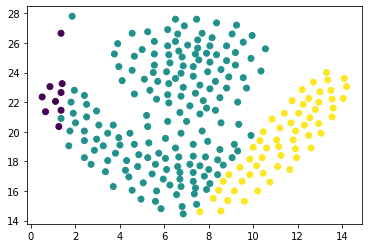

In [27]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/flame_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscanrn_opt_cpp_flame_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, numerate=False)

## OUT

In [28]:
name = 'dbscanrn_opt_cpp_flame_dataset_D2_R240_k7_cosine_dissimilarity_r01'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.004163,NaN
1,2.593457,start log,NaN,NaN,NaN
2,2.818468,normalization_time,NaN,0.224466,NaN
3,2.828079,pessimistic_estimation_time,0.0,0.007863,NaN
4,2.829054,dist_to_ref_point_time,0.0,0.000344,NaN


In [29]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,1.85,27.80,1,3,7.0
1,1,1.35,26.65,1,2,7.0
2,2,1.40,23.25,1,2,7.0
3,3,0.85,23.05,1,2,7.0
4,4,0.50,22.35,1,2,7.0


## STAT

In [30]:
params = {
    'k': 7,
    'similarity': 'cosine_dissimilarity'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [31]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "knn_time [ms]": logs[logs['operation'] == 'knn_time']['value'].sum() * 1000,
    "rnn_time [ms]": logs[logs['operation'] == 'rnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.015566825866699219


,values
name of the input fil,flame_dataset
# of dimensions of a point,2
# of points in the input file,240
epsilon,
minPts,
k,7
similarity,cosine_dissimilarity
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],4.1632
normalization of vectors [ms],


## DEBUG

In [32]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,7.0,15;14;16;2;7;1;6;,7.0,15;14;16;2;7;1;6;
1,1.0,7.0,6;7;2;16;3;14;15;,7.0,6;7;2;16;3;14;15;
2,2.0,7.0,7;16;14;15;0;1;6;,7.0,7;16;14;15;0;1;6;
3,3.0,7.0,5;4;6;1;7;2;16;,7.0,5;4;6;1;7;2;16;
4,4.0,7.0,5;3;6;1;7;2;16;,7.0,5;3;6;1;7;2;16;


# R15 dataset

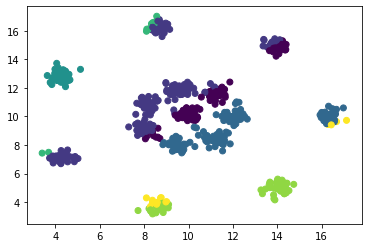

In [33]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/R15_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscanrn_opt_cpp_R15_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, numerate=False)

## OUT

In [34]:
name = 'dbscanrn_opt_cpp_R15_dataset_D2_R600_k9_cosine_dissimilarity_r01'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.005694,NaN
1,3.771402,start log,NaN,NaN,NaN
2,5.174141,normalization_time,NaN,1.402120,NaN
3,5.196060,pessimistic_estimation_time,0.0,0.019310,NaN
4,5.197565,dist_to_ref_point_time,0.0,0.000794,NaN


In [35]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,9.802,10.132,1,2,9.0
1,1,10.350,9.768,1,2,9.0
2,2,10.098,9.988,1,2,9.0
3,3,9.730,9.910,1,2,9.0
4,4,9.754,10.430,1,2,9.0


## STAT

In [36]:
params = {
    'k': 9,
    'similarity': 'cosine_dissimilarity'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [37]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "knn_time [ms]": logs[logs['operation'] == 'knn_time']['value'].sum() * 1000,
    "rnn_time [ms]": logs[logs['operation'] == 'rnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.017123699188232422


,values
name of the input fil,R15_dataset
# of dimensions of a point,2
# of points in the input file,600
epsilon,
minPts,
k,9
similarity,cosine_dissimilarity
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],5.6943
normalization of vectors [ms],


## DEBUG

In [38]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,9.0,94;361;7;88;117;30;84;204;21;,9.0,94;361;7;88;117;30;84;204;21;
1,1.0,9.0,29;27;87;16;32;19;6;31;8;,9.0,29;27;87;16;32;19;6;31;8;
2,2.0,9.0,89;95;113;245;38;34;35;221;106;,9.0,89;95;113;245;38;34;35;221;106;
3,3.0,9.0,374;360;18;104;119;380;26;384;90;,9.0,374;360;18;104;119;380;26;384;90;
4,4.0,9.0,378;395;22;92;93;399;381;37;362;,9.0,378;395;22;92;93;399;381;37;362;
